In [57]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns

In [2]:
import numpy as np

In [3]:
import matplotlib.cbook as cbook

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['font.sans-serif'] = ['SimHei']

In [5]:
import statsmodels.api as sm

In [6]:
pd.set_option("display.float_format", "{:,.3f}".format)

# Qustion: how kol spending effectiveness is affected by product/media/kol tiers/ec platform/seasonality?

# EDA and data cleaning

In [152]:
#read data
df = pd.read_excel('/Users/daniel/Downloads/Data Needs FOR RGM - social part.xlsx', sheet_name='social by day(PM)')

In [153]:
#check columns
df.columns

Index(['商品名称', '日期(BY DAY)', '站外平台', 'spendning', 'KOL(昵称)', 'KOL Tier（粉丝数）',
       '声量（转评赞）', 'EC platform（TMALL/JD）'],
      dtype='object')

In [154]:
df.head()

,商品名称,日期(BY DAY),站外平台,spendning,KOL(昵称),KOL Tier（粉丝数）,声量（转评赞）,EC platform（TMALL/JD）
0,HS礼盒,2019-10-26,微博/微信,"152,000.000",卧蚕阿姨,"3,810,000.000",17026,TMALL
1,HS礼盒,2019-10-27,微信,"105,000.000",Lisa的美妆日记,"1,500,000.000",1230,TMALL
2,HS礼盒,2019-10-27,微博,"10,680.000",Mog不是蘑菇,"1,540,000.000",7798,TMALL
3,HS礼盒,2019-10-28,微博,"120,840.000",MK凉凉,"5,180,000.000",1193,TMALL
4,HS礼盒,2019-10-30,微博,"61,280.000",Bee哥大哥大,"1,630,000.000",4700,TMALL


In [155]:
#change column names
df.rename(columns={'商品名称':'prod',
                   '日期(BY DAY)':'date',
                  '站外平台':'media',
                  'spendning':'spending',
                  'KOL(昵称)':'kol',
                  'KOL Tier（粉丝数）':'kol_fans',
                  '声量（转评赞）':'buzz',
                  'EC platform（TMALL/JD）':'ec_plat'}, inplace=True)

In [156]:
#check data type, 'buzz' type incorrect and 4 missing data for spending
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   prod      631 non-null    object        
 1   date      631 non-null    datetime64[ns]
 2   media     631 non-null    object        
 3   spending  627 non-null    float64       
 4   kol       631 non-null    object        
 5   kol_fans  631 non-null    float64       
 6   buzz      631 non-null    object        
 7   ec_plat   631 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 39.6+ KB


In [157]:
#remove live streaming platform data, as engagement is not available for these platforms.
df = df.query('media not in ["京东直播","天猫直播","斗鱼","虎牙"]')

In [158]:
#remove data that spending is empty
df = df[~df.spending.isnull()]

In [159]:
#change 'buzz' data type
df['buzz'] = df['buzz'].astype('int')

In [160]:
df.head()

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat
0,HS礼盒,2019-10-26,微博/微信,"152,000.000",卧蚕阿姨,"3,810,000.000",17026,TMALL
1,HS礼盒,2019-10-27,微信,"105,000.000",Lisa的美妆日记,"1,500,000.000",1230,TMALL
2,HS礼盒,2019-10-27,微博,"10,680.000",Mog不是蘑菇,"1,540,000.000",7798,TMALL
3,HS礼盒,2019-10-28,微博,"120,840.000",MK凉凉,"5,180,000.000",1193,TMALL
4,HS礼盒,2019-10-30,微博,"61,280.000",Bee哥大哥大,"1,630,000.000",4700,TMALL


In [161]:
df.describe()

,spending,kol_fans,buzz
count,614.000,614.000,614.000
mean,"57,864.495","956,505.761","38,908.775"
std,"90,934.426","3,096,008.609","149,386.870"
min,250.000,20.000,0.000
25%,"4,105.000",272.250,325.500
50%,"21,000.000","3,937.500","2,470.000"
75%,"75,000.000","213,750.000","17,230.250"
max,"720,000.000","41,830,000.000","2,222,012.000"


In [162]:
df.groupby('media')['buzz'].describe()

,count,mean,std,min,25%,50%,75%,max
media,,,,,,,,
B站,6.000,"3,236.333","1,617.670","1,288.000","2,057.000","3,112.500","4,331.500","5,462.000"
B站/微博,2.000,"11,850.000","10,163.953","4,663.000","8,256.500","11,850.000","15,443.500","19,037.000"
tiktok,264.000,"88,414.886","218,375.583",269.000,"8,024.750","23,701.500","71,220.500","2,222,012.000"
小红书,178.000,237.584,248.101,2.000,53.750,184.500,320.750,"1,534.000"
微信,29.000,"4,793.655","4,209.912",308.000,"1,630.000","2,957.000","7,372.000","15,497.000"
微博,131.000,"2,136.573","2,404.934",0.000,569.000,"1,190.000","2,809.500","12,164.000"
微博/微信,1.000,"17,026.000",NaN,"17,026.000","17,026.000","17,026.000","17,026.000","17,026.000"
微博同步全平台,3.000,"9,039.000","12,694.719","1,523.000","1,710.500","1,898.000","12,797.000","23,696.000"


In [163]:
df.groupby('media')['spending'].describe()

,count,mean,std,min,25%,50%,75%,max
media,,,,,,,,
B站,6.000,"45,378.167","37,593.939","6,000.000","13,045.000","41,790.000","72,696.500","96,227.000"
B站/微博,2.000,"103,190.000","39,470.701","75,280.000","89,235.000","103,190.000","117,145.000","131,100.000"
tiktok,264.000,"83,415.802","68,800.985","4,200.000","36,750.000","63,000.000","111,375.000","441,000.000"
小红书,178.000,"7,169.118","8,714.793",250.000,800.000,"3,255.000","10,499.750","52,961.000"
微信,29.000,"290,627.931","199,400.282","18,130.000","132,000.000","261,820.000","420,000.000","720,000.000"
微博,131.000,"20,415.541","44,282.412",450.000,"2,070.000","4,985.000","12,425.000","319,000.000"
微博/微信,1.000,"152,000.000",NaN,"152,000.000","152,000.000","152,000.000","152,000.000","152,000.000"
微博同步全平台,3.000,"165,876.667","6,987.520","159,000.000","162,330.000","165,660.000","169,315.000","172,970.000"


In [164]:
df.groupby('ec_plat')['spending'].describe()

,count,mean,std,min,25%,50%,75%,max
ec_plat,,,,,,,,
JD,89.000,"61,072.629","112,267.476",450.000,"1,635.000","5,500.000","75,000.000","600,000.000"
TMALL,336.000,"85,405.163","97,774.477","1,526.000","26,250.000","55,450.000","112,942.500","720,000.000"
TMALL+JD,165.000,"6,608.115","8,325.271",250.000,800.000,"3,240.000","9,761.000","52,961.000"
VIP,6.000,"15,400.000","5,381.357","7,350.000","11,812.500","17,325.000","18,900.000","21,000.000"
大润发,3.000,"2,173.333",300.888,"1,980.000","2,000.000","2,020.000","2,270.000","2,520.000"
家乐福线下,2.000,"13,062.000","2,316.482","11,424.000","12,243.000","13,062.000","13,881.000","14,700.000"
屈臣氏,10.000,"2,113.800","1,944.883",500.000,600.000,"1,459.000","2,515.000","5,500.000"
屈臣氏线下,3.000,"53,560.000","24,023.807","26,250.000","44,625.000","63,000.000","67,215.000","71,430.000"


In [165]:
#divide kol in 3 tiers
def kol_func(x):
    if x<=100000:
        return 'a:0-10w'
    elif x<=1000000:
        return 'b:10-100w'
    else:
        return 'c:>100w'

In [166]:
df['kol_tier'] = df['kol_fans'].apply(lambda x: kol_func(x))

In [167]:
#create kol efficiency column
df['buzz_per_spd'] = df['buzz']/df['spending']

In [168]:
df['month'] = df['date'].apply(lambda x: x.month)

In [169]:
#TMALL is the most important channel and the most cost effective.
pd.concat([df.groupby('ec_plat')['spending'].sum().sort_values(ascending=False)/df.spending.sum(), df.groupby('ec_plat')['buzz_per_spd'].mean()], axis=1)

,spending,buzz_per_spd
ec_plat,,
TMALL,0.808,0.699
JD,0.153,0.403
TMALL+JD,0.031,0.076
屈臣氏线下,0.005,2.736
VIP,0.003,0.239
家乐福线下,0.001,0.240
屈臣氏,0.001,0.501
大润发,0.000,0.612


In [170]:
df.groupby(['media','kol_tier'])['kol'].count()

media    kol_tier 
B站       a:0-10w        2
         b:10-100w      2
         c:>100w        2
B站/微博    c:>100w        2
tiktok   a:0-10w      264
小红书      a:0-10w      105
         b:10-100w     69
         c:>100w        4
微信       b:10-100w     20
         c:>100w        9
微博       a:0-10w       37
         b:10-100w      4
         c:>100w       90
微博/微信    c:>100w        1
微博同步全平台  b:10-100w      1
         c:>100w        2
Name: kol, dtype: int64

In [389]:
df.groupby(['media','kol_tier']).agg({'buzz_per_spd':'mean','kol':'count'})

buzz_per_spd  kol
media   kol_tier                    
B站      a:0-10w           0.451    2
        b:10-100w         0.090    2
        c:>100w           0.033    2
B站/微博   c:>100w           0.104    2
tiktok  a:0-10w           0.776  262
小红书     a:0-10w           0.101  105
        b:10-100w         0.034   69
        c:>100w           0.008    4
微信      b:10-100w         0.027   20
        c:>100w           0.020    9
微博      a:0-10w           0.555   37
        b:10-100w         0.317    4
        c:>100w           0.290   90
微博/微信   c:>100w           0.112    1
微博同步全平台 b:10-100w         0.009    1
        c:>100w           0.077    2

In [391]:
pd.concat([df.groupby(['media','kol_tier'])['buzz'].sum()/df.groupby(['media','kol_tier'])['spending'].sum(), df.groupby(['media','kol_tier'])['kol'].count()], axis=1)

0  kol
media   kol_tier            
B站      a:0-10w   0.482    2
        b:10-100w 0.066    2
        c:>100w   0.031    2
B站/微博   c:>100w   0.115    2
tiktok  a:0-10w   0.960  262
小红书     a:0-10w   0.069  105
        b:10-100w 0.027   69
        c:>100w   0.007    4
微信      b:10-100w 0.017   20
        c:>100w   0.015    9
微博      a:0-10w   0.496   37
        b:10-100w 0.126    4
        c:>100w   0.092   90
微博/微信   c:>100w   0.112    1
微博同步全平台 b:10-100w 0.009    1
        c:>100w   0.079    2

In [172]:

pd.concat([df.groupby('media')['spending'].sum().sort_values(ascending=False)/df.spending.sum(), df.groupby('media')['buzz_per_spd'].mean()], axis=1)

,spending,buzz_per_spd
media,,
tiktok,0.620,0.897
微信,0.237,0.025
微博,0.075,0.366
小红书,0.036,0.073
微博同步全平台,0.014,0.055
B站,0.008,0.191
B站/微博,0.006,0.104
微博/微信,0.004,0.112


In [173]:
#average buzz_per_spd is the highest for 0-10w kol tier, they are the most cost effective
df.groupby('kol_tier').agg({'spending':'sum','buzz_per_spd':'mean','kol':'count'}).sort_values(by='spending', ascending=False)

,spending,buzz_per_spd,kol
kol_tier,,,
a:0-10w,"22,363,788.856",0.659,408
b:10-100w,"7,190,865.000",0.045,96
c:>100w,"5,974,145.900",0.244,110


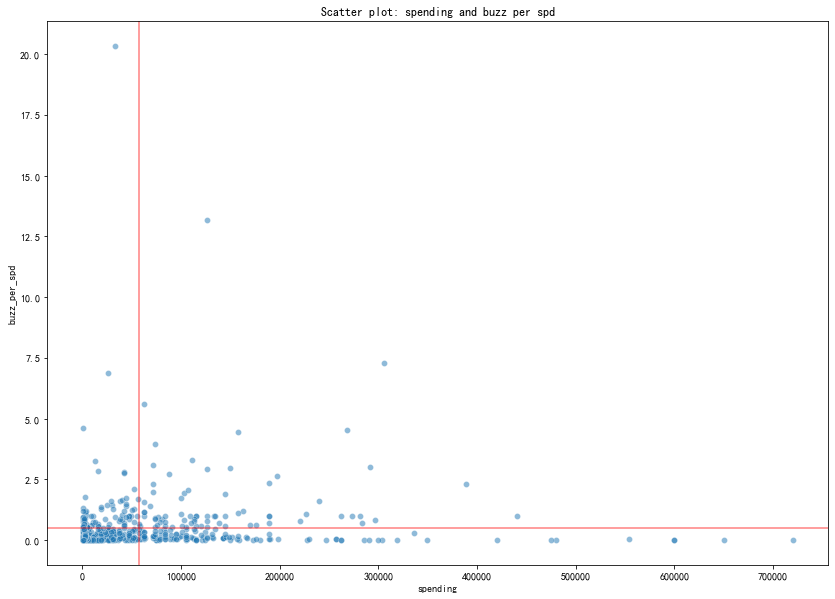

In [174]:
#buzz_per_spd>=12 looks like outliers, need further check
fig = plt.figure(figsize=(14,10))
ax = sns.scatterplot(data=df, x="spending", y="buzz_per_spd", alpha=0.5)
ax.set_title('Scatter plot: spending and buzz per spd')
ax.axhline(df['buzz_per_spd'].mean(),color='r',alpha=0.5)
ax.axvline(df['spending'].mean(),color='r',alpha=0.5)
plt.show()

In [175]:
#check two outliers, looks like the buzz numbers are fake, impossible buzz given kol_fans, 
#remove these two observations
df.query('buzz_per_spd>12')

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat,kol_tier,buzz_per_spd,month
374,欧莱雅男友礼盒,2020-06-11,tiktok,"33,600.000",莫邪,"1,903.000",683474,TMALL,a:0-10w,20.341,6
485,水能套装,2020-11-11,tiktok,"126,000.000",胡玛丽,740.000,1659736,TMALL,a:0-10w,13.173,11


In [176]:
#remove the outliers
df = df.query('buzz_per_spd<=12')

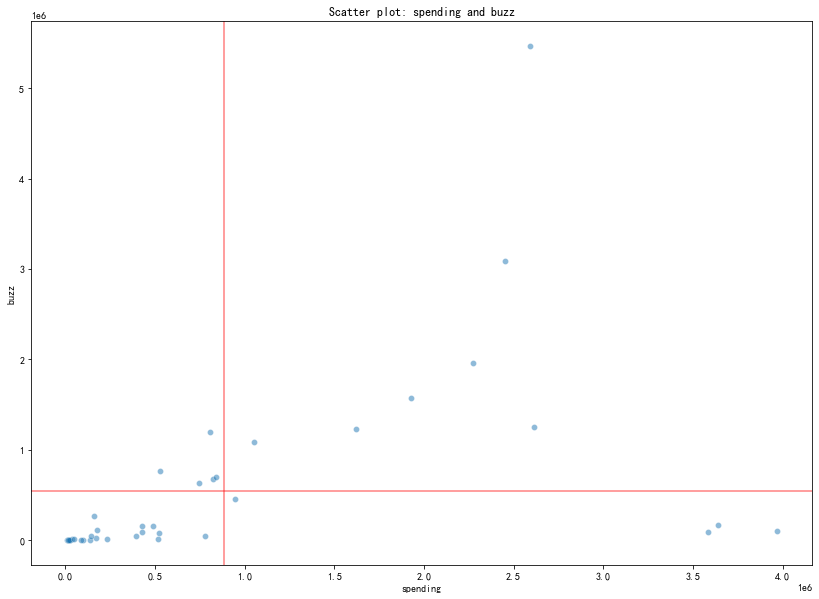

In [290]:
#efficiency by different product campaigns
fig = plt.figure(figsize=(14,10))
df_ = df.groupby('prod').agg({'spending':'sum','buzz':'sum'})
ax = sns.scatterplot(data=df_, x="spending", y="buzz", alpha=0.5)
ax.set_title('Scatter plot: spending and buzz')
ax.axhline(df_['buzz'].mean(),color='r',alpha=0.5)
ax.axvline(df_['spending'].mean(),color='r',alpha=0.5)
plt.show()

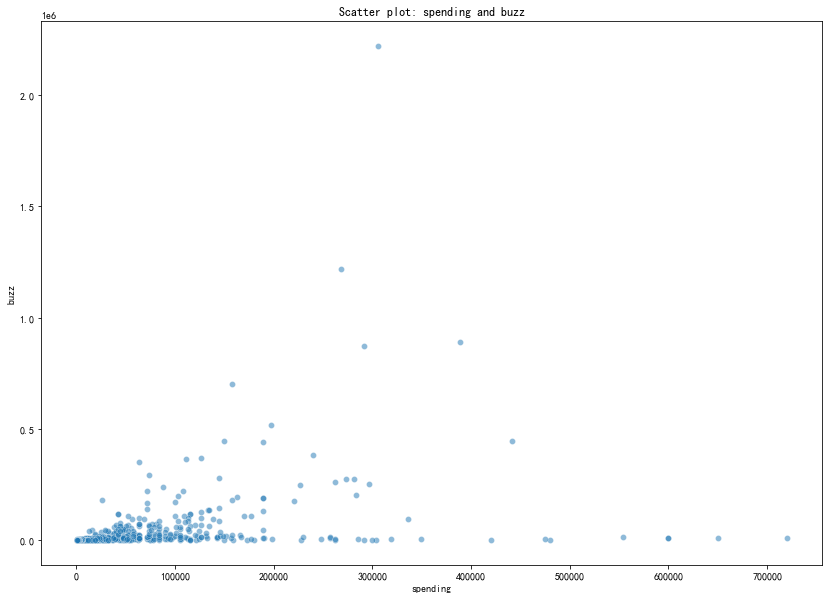

In [187]:
#no significant linear correlation between buzz and spending
fig = plt.figure(figsize=(14,10))
ax = sns.scatterplot(data=df[['spending','buzz']], x="spending", y="buzz", alpha=0.5)
ax.set_title('Scatter plot: spending and buzz')
plt.show()

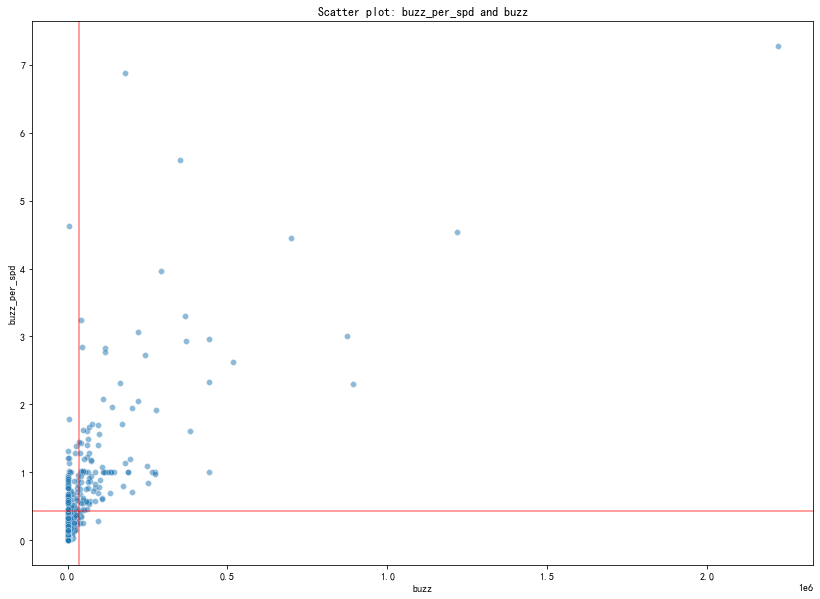

In [179]:
#buzz_per_spd and buzz is positively correlated
fig = plt.figure(figsize=(14,10))
ax = sns.scatterplot(data=df,x="buzz", y="buzz_per_spd", alpha=0.5)
ax.set_title('Scatter plot: buzz_per_spd and buzz')
ax.axhline(df['buzz_per_spd'].mean(),color='r',alpha=0.5)
ax.axvline(df['buzz'].mean(),color='r',alpha=0.5)
plt.show()

In [180]:
df.date.min()

Timestamp('2019-01-03 00:00:00')

In [181]:
df.date.max()

Timestamp('2020-12-30 00:00:00')

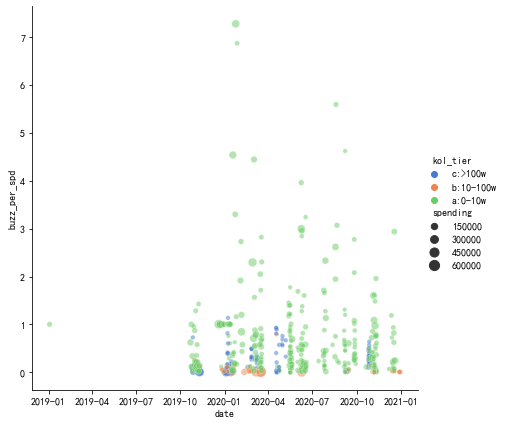

In [182]:
#1. odd point at 2019-01, can be a typo, need further check
#2. there seems to be seasonality, for 2020 CNY, 2020-618, 2021-1111.
#fig = plt.figure(figsize=(14,10))
ax = sns.relplot(data=df[['date','buzz_per_spd','spending','kol_tier']],
                 x="date", y="buzz_per_spd",
                 hue="kol_tier", size="spending",
                 sizes=(20, 120),
                 alpha=.5, 
                 palette="muted",
                 height=6)
plt.show()

In [183]:
#further check jw, seems like the year is typed wrongly for 2019-01-03
df.query('prod=="jw"')

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat,kol_tier,buzz_per_spd,month
261,jw,2019-12-20,tiktok,"441,000.000",七舅脑爷,"2,841.000",443841,TMALL,a:0-10w,1.006,12
262,jw,2019-12-21,tiktok,"133,560.000",逆袭哆哆,"1,094.000",134654,TMALL,a:0-10w,1.008,12
263,jw,2019-12-22,tiktok,"144,900.000",王老六,787.100,145687,TMALL,a:0-10w,1.005,12
264,jw,2019-12-22,tiktok,"189,000.000",黑马小明,677.000,189677,TMALL,a:0-10w,1.004,12
265,jw,2019-12-23,tiktok,"273,000.000",林末范,636.800,273636,TMALL,a:0-10w,1.002,12
266,jw,2019-12-23,tiktok,"262,500.000",神兽阿蛋,579.300,263079,TMALL,a:0-10w,1.002,12
268,jw,2019-12-25,tiktok,"189,000.000",Bigger研究所,535.000,189535,TMALL,a:0-10w,1.003,12
269,jw,2019-12-29,tiktok,"115,500.000",陈采尼,333.000,115833,TMALL,a:0-10w,1.003,12
272,jw,2019-01-03,tiktok,"63,000.000",小颠儿kini,207.000,63207,TMALL,a:0-10w,1.003,1
277,jw,2020-01-11,tiktok,"126,000.000",种草大户萌叔Joey,434.400,126434,TMALL,a:0-10w,1.003,1


In [184]:
#modify the year
df.loc[(df.date=="2019-01-03"),'date']='2020-01-03'

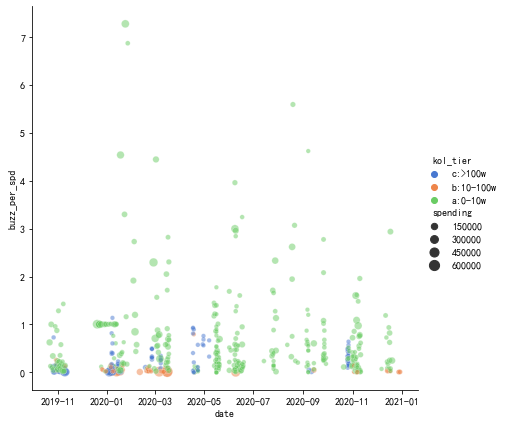

In [186]:
#check the plot again
#seasonality is easier to spot
#some kol (large/mid/small) mix for Christmas/New Year, CNY, Women's day, and 2020 double eleven
#in 2020-05, there seems a test investment for large KOL investment
#looks like 1111 is not as efficient as CNY and women's day's campaigns

ax = sns.relplot(data=df[['date','buzz_per_spd','spending','kol_tier']],
                 x="date", y="buzz_per_spd",
                 hue="kol_tier", size="spending",
                 sizes=(20, 120),
                 alpha=.5, 
                 palette="muted",
                 height=6)
plt.show()

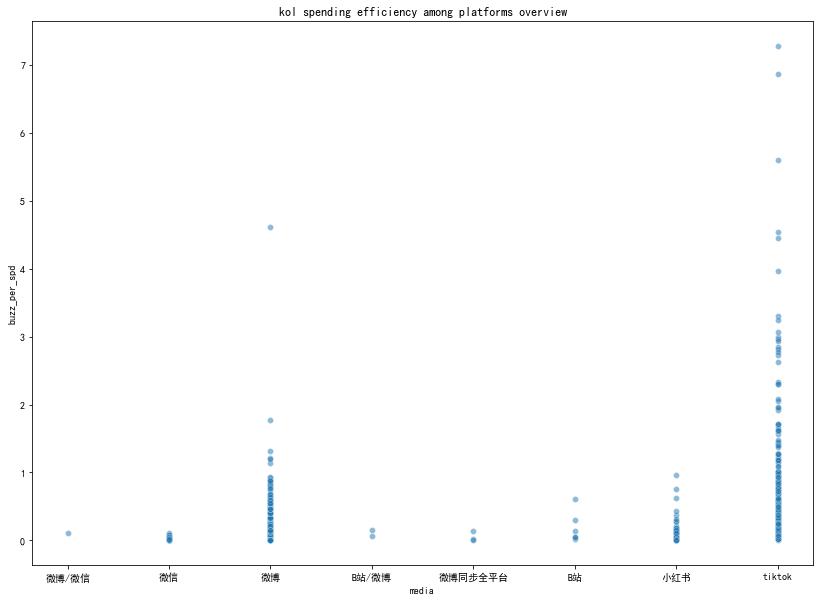

In [58]:
#kol

fig = plt.figure(figsize=(14,10))
ax = sns.scatterplot(data=df, x="media", y="buzz_per_spd", alpha=0.5)
ax.set_title('kol spending efficiency among media overview')
plt.show()

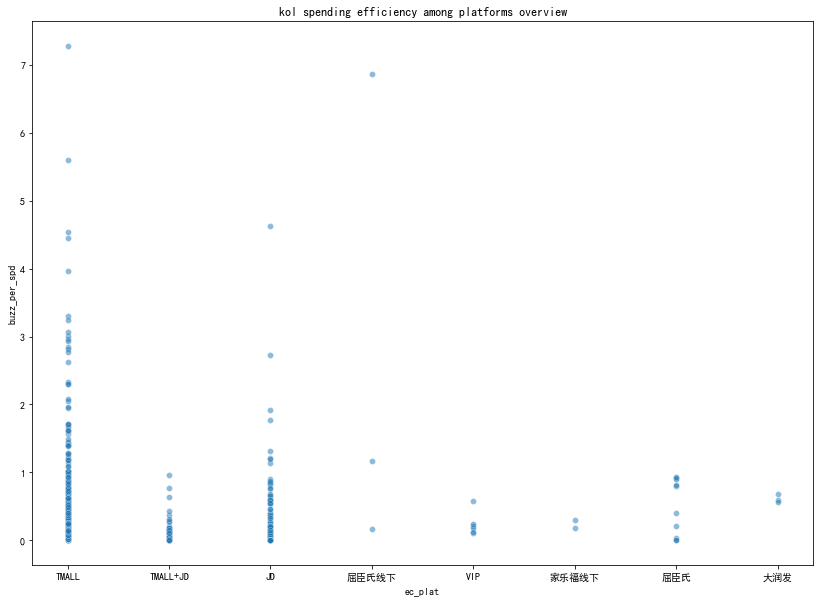

In [35]:
#kol spending efficiency among platforms overview

fig = plt.figure(figsize=(14,10))
ax = sns.scatterplot(data=df[['ec_plat','buzz_per_spd']], x="ec_plat", y="buzz_per_spd", alpha=0.5)
ax.set_title('kol spending efficiency among platforms overview')
plt.show()

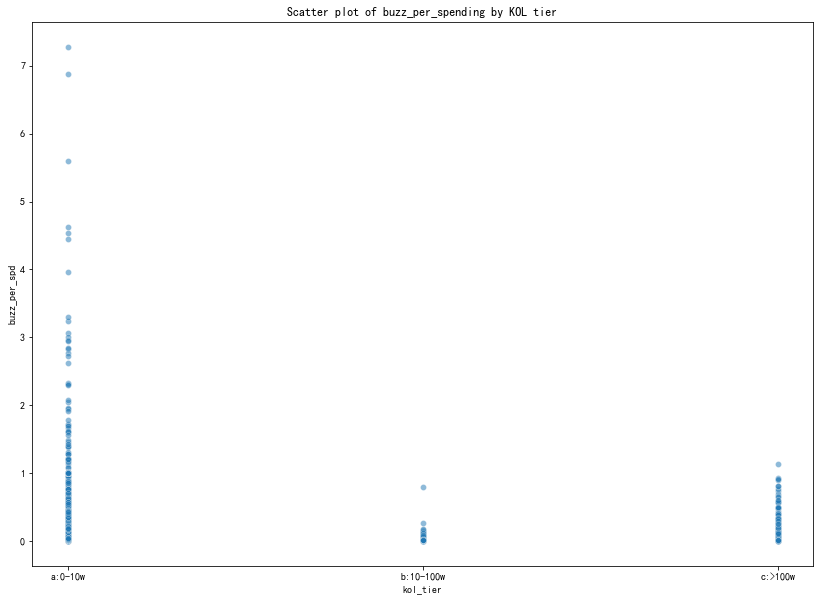

In [36]:
#kol spending efficiency is quite sparse for a:0-10w fans, means their effectively can vary a lot within the group
#kol spending efficiency is condensed for b:10-100w and c>100w

fig = plt.figure(figsize=(14,10))
ax = sns.scatterplot(data=df[['kol_tier','buzz_per_spd']].sort_values(by='kol_tier'), x="kol_tier", y="buzz_per_spd", alpha=0.5)
ax.set_title('Scatter plot of buzz_per_spending by KOL tier')
plt.show()

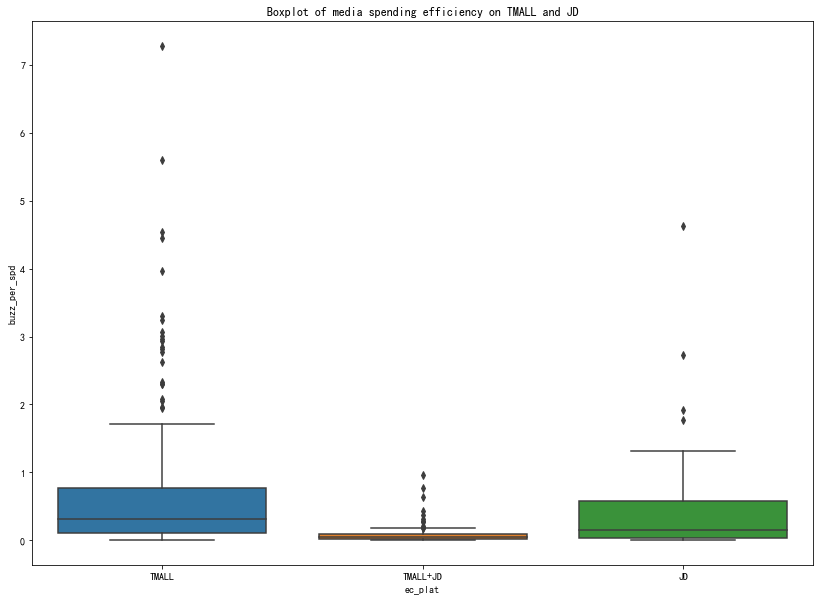

In [37]:
#TMALL buzz_per_spd is slightly higher than JD.
#both TMALL and JD have lots of points above the upper limit generated by boxplot,


fig = plt.figure(figsize=(14,10))
ax = sns.boxplot(data=df.query('ec_plat in ["JD","TMALL","TMALL+JD"]')[['ec_plat','buzz_per_spd']], x="ec_plat", y="buzz_per_spd")
ax.set_title('Boxplot of media spending efficiency on TMALL and JD')
plt.show()

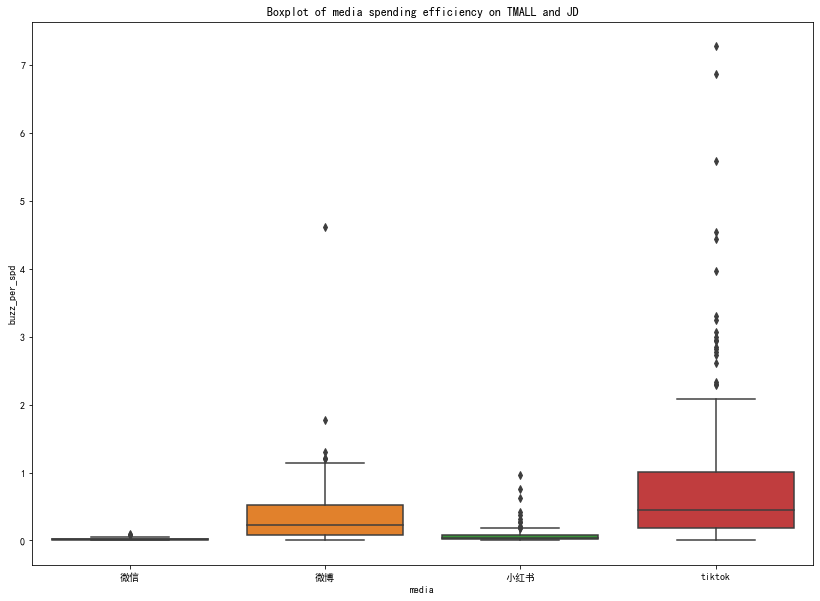

In [84]:
#TMALL buzz_per_spd is slightly higher than JD.
#both TMALL and JD have lots of points above the upper limit generated by boxplot,

fig = plt.figure(figsize=(14,10))
ax = sns.boxplot(data=df.query('media not in ["B站","B站/微博","微博同步全平台","微博/微信"]')[['media','buzz_per_spd']], x="media", y="buzz_per_spd")
ax.set_title('Boxplot of media spending efficiency on TMALL and JD')
plt.show()

# Causality analysis by using OLS model

In [38]:
df.head()

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat,kol_tier,buzz_per_spd,month
0,HS礼盒,2019-10-26,微博/微信,"152,000.000",卧蚕阿姨,"3,810,000.000",17026,TMALL,c:>100w,0.112,10
1,HS礼盒,2019-10-27,微信,"105,000.000",Lisa的美妆日记,"1,500,000.000",1230,TMALL,c:>100w,0.012,10
2,HS礼盒,2019-10-27,微博,"10,680.000",Mog不是蘑菇,"1,540,000.000",7798,TMALL,c:>100w,0.730,10
3,HS礼盒,2019-10-28,微博,"120,840.000",MK凉凉,"5,180,000.000",1193,TMALL,c:>100w,0.010,10
4,HS礼盒,2019-10-30,微博,"61,280.000",Bee哥大哥大,"1,630,000.000",4700,TMALL,c:>100w,0.077,10


In [243]:
df.media.unique()

array(['微博/微信', '微信', '微博', 'B站/微博', '微博同步全平台', 'B站', '小红书', 'tiktok'],
      dtype=object)

In [291]:
df

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat,kol_tier,buzz_per_spd,month
0,HS礼盒,2019-10-26,微博/微信,"152,000.000",卧蚕阿姨,"3,810,000.000",17026,TMALL,c:>100w,0.112,10
1,HS礼盒,2019-10-27,微信,"105,000.000",Lisa的美妆日记,"1,500,000.000",1230,TMALL,c:>100w,0.012,10
2,HS礼盒,2019-10-27,微博,"10,680.000",Mog不是蘑菇,"1,540,000.000",7798,TMALL,c:>100w,0.730,10
3,HS礼盒,2019-10-28,微博,"120,840.000",MK凉凉,"5,180,000.000",1193,TMALL,c:>100w,0.010,10
4,HS礼盒,2019-10-30,微博,"61,280.000",Bee哥大哥大,"1,630,000.000",4700,TMALL,c:>100w,0.077,10
...,...,...,...,...,...,...,...,...,...,...,...
626,欧莱雅男士套装,2020-09-07,微博,"1,101.000",护肤小常识,452.000,610,JD,a:0-10w,0.554,9
627,欧莱雅男士套装,2020-09-07,微博,"1,535.000",潮人生活,360.000,703,JD,a:0-10w,0.458,9
628,欧莱雅男士套装,2020-09-07,微博,"1,304.000",指尖看时尚,937.000,9,JD,a:0-10w,0.007,9
629,欧莱雅男士套装,2020-09-07,微博,961.000,美妆编发教程,125.000,5,JD,a:0-10w,0.005,9


In [248]:
col_names = ['d_'+i for i in df.media.unique()]

In [249]:
col_names

['d_微博/微信',
 'd_微信',
 'd_微博',
 'd_B站/微博',
 'd_微博同步全平台',
 'd_B站',
 'd_小红书',
 'd_tiktok']

In [244]:
ls=[]
for i in df.media.unique():
    tmp = df['media']==i
    ls.append(tmp)

In [252]:
apx = pd.concat(ls, axis=1)

In [253]:
apx.columns = col_names

In [256]:
apx = apx*1

In [257]:
apx

,d_微博/微信,d_微信,d_微博,d_B站/微博,d_微博同步全平台,d_B站,d_小红书,d_tiktok
0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
626,0,0,1,0,0,0,0,0
627,0,0,1,0,0,0,0,0
628,0,0,1,0,0,0,0,0
629,0,0,1,0,0,0,0,0


In [261]:
df_ = pd.concat([df, apx], axis=1)

In [262]:
df_

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat,kol_tier,buzz_per_spd,month,d_微博/微信,d_微信,d_微博,d_B站/微博,d_微博同步全平台,d_B站,d_小红书,d_tiktok
0,HS礼盒,2019-10-26,微博/微信,"152,000.000",卧蚕阿姨,"3,810,000.000",17026,TMALL,c:>100w,0.112,10,1,0,0,0,0,0,0,0
1,HS礼盒,2019-10-27,微信,"105,000.000",Lisa的美妆日记,"1,500,000.000",1230,TMALL,c:>100w,0.012,10,0,1,0,0,0,0,0,0
2,HS礼盒,2019-10-27,微博,"10,680.000",Mog不是蘑菇,"1,540,000.000",7798,TMALL,c:>100w,0.730,10,0,0,1,0,0,0,0,0
3,HS礼盒,2019-10-28,微博,"120,840.000",MK凉凉,"5,180,000.000",1193,TMALL,c:>100w,0.010,10,0,0,1,0,0,0,0,0
4,HS礼盒,2019-10-30,微博,"61,280.000",Bee哥大哥大,"1,630,000.000",4700,TMALL,c:>100w,0.077,10,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,欧莱雅男士套装,2020-09-07,微博,"1,101.000",护肤小常识,452.000,610,JD,a:0-10w,0.554,9,0,0,1,0,0,0,0,0
627,欧莱雅男士套装,2020-09-07,微博,"1,535.000",潮人生活,360.000,703,JD,a:0-10w,0.458,9,0,0,1,0,0,0,0,0
628,欧莱雅男士套装,2020-09-07,微博,"1,304.000",指尖看时尚,937.000,9,JD,a:0-10w,0.007,9,0,0,1,0,0,0,0,0
629,欧莱雅男士套装,2020-09-07,微博,961.000,美妆编发教程,125.000,5,JD,a:0-10w,0.005,9,0,0,1,0,0,0,0,0


In [223]:
df.groupby(['kol_tier','media','prod','month'])['kol'].count()

kol_tier  media    prod    month
a:0-10w   B站       HS礼盒    1         2
          tiktok   DUO     10        2
                           11        4
                   Duo     1         6
                           3        20
                                    ..
c:>100w   微博       锐能紧致套装  3         5
                           4         3
          微博/微信    HS礼盒    10        1
          微博同步全平台  HS礼盒    1         1
                           11        1
Name: kol, Length: 111, dtype: int64

In [196]:
df_reg = df.groupby(['kol_tier','media','month']).agg({'kol':'nunique','spending':'sum','buzz':'sum','date':'nunique'}).reset_index()

In [115]:
df_reg['month'] = df_reg['month'].astype('str')

In [224]:
org = pd.concat([pd.get_dummies(df[['media']]), df[['kol_fans', 'spending', 'buzz']]], axis=1)

In [225]:
org['buzz_per_spd']=org['buzz']/org['spending']

In [226]:
org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 630
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   media_B站       612 non-null    uint8  
 1   media_B站/微博    612 non-null    uint8  
 2   media_tiktok   612 non-null    uint8  
 3   media_小红书      612 non-null    uint8  
 4   media_微信       612 non-null    uint8  
 5   media_微博       612 non-null    uint8  
 6   media_微博/微信    612 non-null    uint8  
 7   media_微博同步全平台  612 non-null    uint8  
 8   kol_fans       612 non-null    float64
 9   spending       612 non-null    float64
 10  buzz           612 non-null    int64  
 11  buzz_per_spd   612 non-null    float64
dtypes: float64(3), int64(1), uint8(8)
memory usage: 44.9 KB


In [229]:
org['ln_kol_fans'] = org['kol_fans'].apply(lambda x: np.log(x))

In [234]:
org['ln_kol_fans']

0     15.153
1     14.221
2     14.247
3     15.460
4     14.304
       ...  
626    6.114
627    5.886
628    6.843
629    4.828
630    5.112
Name: ln_kol_fans, Length: 612, dtype: float64

In [236]:
X = pd.concat([org[org.columns[:-5]],org['ln_kol_fans']],axis=1)

In [265]:
df_.columns

Index(['prod', 'date', 'media', 'spending', 'kol', 'kol_fans', 'buzz',
       'ec_plat', 'kol_tier', 'buzz_per_spd', 'month', 'd_微博/微信', 'd_微信',
       'd_微博', 'd_B站/微博', 'd_微博同步全平台', 'd_B站', 'd_小红书', 'd_tiktok'],
      dtype='object')

In [266]:
df_['ln_kol_fans'] = df_['kol_fans'].apply(lambda x: np.log(x))

In [267]:
df_.head()

,prod,date,media,spending,kol,kol_fans,buzz,ec_plat,kol_tier,buzz_per_spd,month,d_微博/微信,d_微信,d_微博,d_B站/微博,d_微博同步全平台,d_B站,d_小红书,d_tiktok,ln_kol_fans
0,HS礼盒,2019-10-26,微博/微信,"152,000.000",卧蚕阿姨,"3,810,000.000",17026,TMALL,c:>100w,0.112,10,1,0,0,0,0,0,0,0,15.153
1,HS礼盒,2019-10-27,微信,"105,000.000",Lisa的美妆日记,"1,500,000.000",1230,TMALL,c:>100w,0.012,10,0,1,0,0,0,0,0,0,14.221
2,HS礼盒,2019-10-27,微博,"10,680.000",Mog不是蘑菇,"1,540,000.000",7798,TMALL,c:>100w,0.730,10,0,0,1,0,0,0,0,0,14.247
3,HS礼盒,2019-10-28,微博,"120,840.000",MK凉凉,"5,180,000.000",1193,TMALL,c:>100w,0.010,10,0,0,1,0,0,0,0,0,15.460
4,HS礼盒,2019-10-30,微博,"61,280.000",Bee哥大哥大,"1,630,000.000",4700,TMALL,c:>100w,0.077,10,0,0,1,0,0,0,0,0,14.304


In [282]:
X = pd.concat([df_[['d_小红书','ln_kol_fans']],df_['buzz_per_spd']],axis=1)

In [ ]:
X_

In [286]:
X= df_[['d_小红书','ln_kol_fans']]

In [211]:
org.head()

,kol_tier_a:0-10w,kol_tier_b:10-100w,kol_tier_c:>100w,media_B站,media_B站/微博,media_tiktok,media_小红书,media_微信,media_微博,media_微博/微信,media_微博同步全平台,date,kol,spending,buzz,buzz_per_spd
0,0,0,1,0,0,0,0,0,0,1,0,2019-10-26,卧蚕阿姨,"152,000.000",17026,0.112
1,0,0,1,0,0,0,0,1,0,0,0,2019-10-27,Lisa的美妆日记,"105,000.000",1230,0.012
2,0,0,1,0,0,0,0,0,1,0,0,2019-10-27,Mog不是蘑菇,"10,680.000",7798,0.730
3,0,0,1,0,0,0,0,0,1,0,0,2019-10-28,MK凉凉,"120,840.000",1193,0.010
4,0,0,1,0,0,0,0,0,1,0,0,2019-10-30,Bee哥大哥大,"61,280.000",4700,0.077


In [212]:
org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612 entries, 0 to 630
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   kol_tier_a:0-10w    612 non-null    uint8         
 1   kol_tier_b:10-100w  612 non-null    uint8         
 2   kol_tier_c:>100w    612 non-null    uint8         
 3   media_B站            612 non-null    uint8         
 4   media_B站/微博         612 non-null    uint8         
 5   media_tiktok        612 non-null    uint8         
 6   media_小红书           612 non-null    uint8         
 7   media_微信            612 non-null    uint8         
 8   media_微博            612 non-null    uint8         
 9   media_微博/微信         612 non-null    uint8         
 10  media_微博同步全平台       612 non-null    uint8         
 11  date                612 non-null    datetime64[ns]
 12  kol                 612 non-null    object        
 13  spending            612 non-null    float64       

In [204]:
org.shape

(612, 16)

In [119]:
df_reg.query('month=="9"')

,prod,ec_plat,kol_tier,media,month,kol,spending,buzz,date
48,duo,JD,a:0-10w,tiktok,9,1,"30,332.000",1923,1
50,duo,家乐福线下,a:0-10w,tiktok,9,2,"26,124.000",6468,1
58,七龙珠洗面奶套装,JD,b:10-100w,B站,9,1,"96,227.000",4677,1
59,七龙珠洗面奶套装,JD,c:>100w,B站,9,2,"135,862.000",4218,2
67,欧莱雅男士套装,JD,a:0-10w,微博,9,15,"20,121.000",13031,3
71,水能套装,JD,a:0-10w,tiktok,9,1,"12,600.000",2417,1
72,水能套装,TMALL,a:0-10w,tiktok,9,15,"729,476.980",561744,2
77,水能套装,VIP,a:0-10w,tiktok,9,1,"10,500.000",1277,1
114,黑白JW,JD,a:0-10w,tiktok,9,1,"176,400.000",106838,1


In [120]:
org.columns

Index(['prod_DUO', 'prod_Duo', 'prod_HE Serum', 'prod_HP', 'prod_HS',
       'prod_HS礼盒', 'prod_JELLYWASH', 'prod_JW', 'prod_MA8', 'prod_Vitalift眼霜',
       'prod_duo', 'prod_duo ', 'prod_duo套装', 'prod_he serum', 'prod_jw',
       'prod_ma8劲能醒肤露', 'prod_vt男士锐能眼霜', 'prod_七龙珠洗面奶套装', 'prod_屈臣氏线下探店',
       'prod_控油+水能 爽肤水', 'prod_控油爽肤水', 'prod_欧莱雅男友礼盒', 'prod_欧莱雅男士劲能醒肤露',
       'prod_欧莱雅男士套装', 'prod_氨基酸洗面奶', 'prod_水能套装', 'prod_水能套装puma联名版',
       'prod_水能爽肤水', 'prod_水能男士套装', 'prod_洗面奶套装', 'prod_淡痘印洗面奶', 'prod_爽肤水',
       'prod_男士水能保湿增强爽肤水', 'prod_男士舒润套装', 'prod_男士香氛爽肤水', 'prod_舒润套装',
       'prod_进口水', 'prod_锐能四件套', 'prod_锐能紧致套装', 'prod_黑白JW', 'ec_plat_JD',
       'ec_plat_TMALL', 'ec_plat_TMALL+JD', 'ec_plat_VIP', 'ec_plat_大润发',
       'ec_plat_家乐福线下', 'ec_plat_屈臣氏', 'ec_plat_屈臣氏线下', 'kol_tier_a:0-10w',
       'kol_tier_b:10-100w', 'kol_tier_c:>100w', 'media_B站', 'media_B站/微博',
       'media_tiktok', 'media_小红书', 'media_微信', 'media_微博', 'media_微博/微信',
       'media_微博同步全平台', 'month_1'

In [121]:
test = pd.concat([pd.get_dummies(df_reg[['kol_tier','media']]), df_reg[['date','kol', 'spending', 'buzz']]], axis=1)

In [122]:
test['buzz_per_spd']=test['buzz']/test['spending']

In [123]:
test.rename(columns = {'date':'days_cnt','kol':'kol_cnt'}, inplace=True)

In [124]:
test.head()

,kol_tier_a:0-10w,kol_tier_b:10-100w,kol_tier_c:>100w,media_B站,media_B站/微博,media_tiktok,media_小红书,media_微信,media_微博,media_微博/微信,media_微博同步全平台,days_cnt,kol_cnt,spending,buzz,buzz_per_spd
0,1,0,0,0,0,1,0,0,0,0,0,2,2,"152,560.000",18071,0.118
1,1,0,0,0,0,1,0,0,0,0,0,3,4,"272,970.000",74080,0.271
2,1,0,0,0,0,1,0,0,0,0,0,6,6,"313,950.000",315653,1.005
3,1,0,0,0,0,1,0,0,0,0,0,5,20,"1,427,331.000",1062892,0.745
4,1,0,0,0,0,1,0,0,0,0,0,3,3,"188,882.000",190082,1.006


In [125]:
~test.columns.isin(["media_B站/微博","media_微博/微信"])

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True])

In [126]:
test_ = test[test.columns[~test.columns.isin(["media_B站/微博","media_微博/微信","media_微博同步全平台"])]]

In [386]:
df.groupby('kol_tier')['prod'].count()

kol_tier
a:0-10w      406
b:10-100w     96
c:>100w      110
Name: prod, dtype: int64

In [385]:
df.query('media=="小红书"').groupby('kol_tier')['prod'].count()

kol_tier
a:0-10w      105
b:10-100w     69
c:>100w        4
Name: prod, dtype: int64

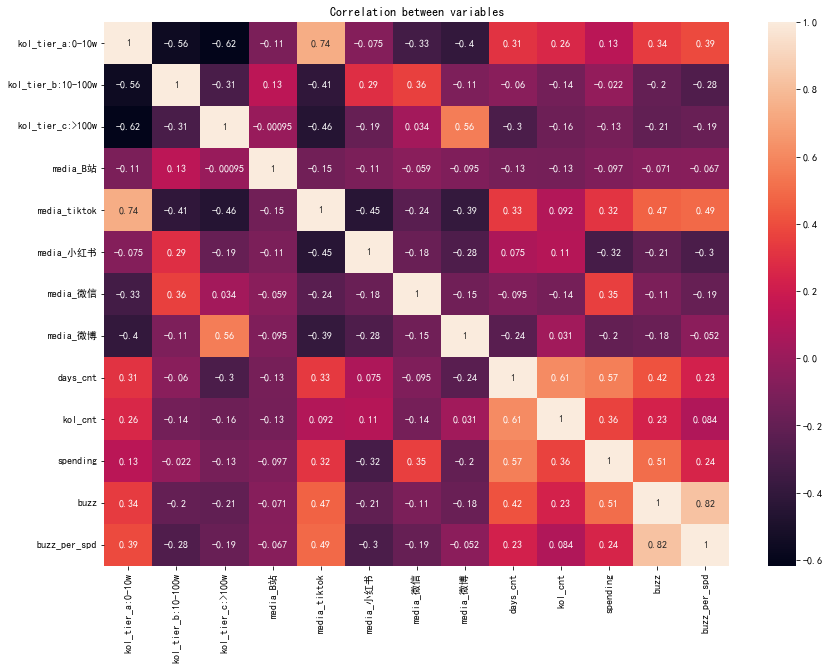

In [127]:
#campaign days count seems to be highly correlated with kol_cnt, 
#drop days_cnt
#kol_tier 0-10w are mostly on tiktok
fig = plt.figure(figsize=(14,10))
ax = sns.heatmap(test_[test_.columns[:]].corr(), annot=True)
ax.set_title('Correlation between variables')
plt.show()

In [49]:
org.drop(columns=['date'], inplace=True)

In [50]:
org.columns

Index(['prod_DUO', 'prod_Duo', 'prod_HE Serum', 'prod_HP', 'prod_HS',
       'prod_HS礼盒', 'prod_JELLYWASH', 'prod_JW', 'prod_MA8', 'prod_Vitalift眼霜',
       'prod_duo', 'prod_duo ', 'prod_duo套装', 'prod_he serum', 'prod_jw',
       'prod_ma8劲能醒肤露', 'prod_vt男士锐能眼霜', 'prod_七龙珠洗面奶套装', 'prod_屈臣氏线下探店',
       'prod_控油+水能 爽肤水', 'prod_控油爽肤水', 'prod_欧莱雅男友礼盒', 'prod_欧莱雅男士劲能醒肤露',
       'prod_欧莱雅男士套装', 'prod_氨基酸洗面奶', 'prod_水能套装', 'prod_水能套装puma联名版',
       'prod_水能爽肤水', 'prod_水能男士套装', 'prod_洗面奶套装', 'prod_淡痘印洗面奶', 'prod_爽肤水',
       'prod_男士水能保湿增强爽肤水', 'prod_男士舒润套装', 'prod_男士香氛爽肤水', 'prod_舒润套装',
       'prod_进口水', 'prod_锐能四件套', 'prod_锐能紧致套装', 'prod_黑白JW', 'ec_plat_JD',
       'ec_plat_TMALL', 'ec_plat_TMALL+JD', 'ec_plat_VIP', 'ec_plat_大润发',
       'ec_plat_家乐福线下', 'ec_plat_屈臣氏', 'ec_plat_屈臣氏线下', 'kol_tier_a:0-10w',
       'kol_tier_b:10-100w', 'kol_tier_c:>100w', 'media_B站', 'media_B站/微博',
       'media_tiktok', 'media_小红书', 'media_微信', 'media_微博', 'media_微博/微信',
       'media_微博同步全平台', 'month_1'

In [51]:
org[org.columns[:-3]]

,prod_DUO,prod_Duo,prod_HE Serum,prod_HP,prod_HS,prod_HS礼盒,prod_JELLYWASH,prod_JW,prod_MA8,prod_Vitalift眼霜,...,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,kol
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,20
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
111,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,5
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,15


In [215]:
X = org[org.columns[:-5]]

In [350]:
X = pd.concat([pd.get_dummies(df['media']), df[['kol_fans','spending']]], axis=1)

In [344]:
X = pd.concat([pd.get_dummies(df['media'],drop_first=True), df[['kol_fans','spending']]], axis=1)

In [345]:
X.head()

,B站/微博,tiktok,小红书,微信,微博,微博/微信,微博同步全平台,kol_fans,spending
0,0,0,0,0,0,1,0,"3,810,000.000","152,000.000"
1,0,0,0,1,0,0,0,"1,500,000.000","105,000.000"
2,0,0,0,0,1,0,0,"1,540,000.000","10,680.000"
3,0,0,0,0,1,0,0,"5,180,000.000","120,840.000"
4,0,0,0,0,1,0,0,"1,630,000.000","61,280.000"


In [313]:
X['redbook_x_spending'] = X['小红书']*X['spending']

In [315]:
X['wechat_x_spending'] = X['微信']*X['spending']

In [316]:
X['weibo_x_spending'] = X['微博']*X['spending']

In [317]:
X['tiktok_x_spending'] = X['tiktok']*X['spending']

In [319]:
X['redbook_x_kolfans'] = X['小红书']*X['kol_fans']
X['wechat_x_kolfans'] = X['微信']*X['kol_fans']
X['weibo_x_kolfans'] = X['微博']*X['kol_fans']
X['tiktok_x_kolfans'] = X['tiktok']*X['kol_fans']


In [320]:
X.head()

,const,B站,B站/微博,tiktok,小红书,微信,微博,微博/微信,微博同步全平台,kol_fans,spending,redbook_x_spending,wechat_x_spending,weibo_x_spending,tiktok_x_spending,redbook_x_kolfans,wechat_x_kolfans,weibo_x_kolfans,tiktok_x_kolfans
0,1.000,0,0,0,0,0,0,1,0,"3,810,000.000","152,000.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,0,0,0,0,1,0,0,0,"1,500,000.000","105,000.000",0.000,"105,000.000",0.000,0.000,0.000,"1,500,000.000",0.000,0.000
2,1.000,0,0,0,0,0,1,0,0,"1,540,000.000","10,680.000",0.000,0.000,"10,680.000",0.000,0.000,0.000,"1,540,000.000",0.000
3,1.000,0,0,0,0,0,1,0,0,"5,180,000.000","120,840.000",0.000,0.000,"120,840.000",0.000,0.000,0.000,"5,180,000.000",0.000
4,1.000,0,0,0,0,0,1,0,0,"1,630,000.000","61,280.000",0.000,0.000,"61,280.000",0.000,0.000,0.000,"1,630,000.000",0.000


In [353]:
y = df['buzz']

In [ ]:
X1 = df[['spending','kol_fans','kolfans']

In [354]:
import statsmodels.formula.api as smf

In [361]:
df.query('date>="2020-01-01" and media=="tiktok"').date.min()

Timestamp('2020-01-03 00:00:00')

In [374]:
regr = smf.ols(formula='buzz ~ spending+kol_fans+spending*kol_fans', 
               data=df.query('date>="2020-01-01" and media=="tiktok"')) 
model2 = regr.fit()

In [375]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     79.49
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           8.00e-35
Time:                        22:37:49   Log-Likelihood:                -2961.6
No. Observations:                 223   AIC:                             5931.
Df Residuals:                     219   BIC:                             5945.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.253e+04   2.18e+0

In [376]:
regr3 = smf.ols(formula='buzz ~ spending+kol_fans+spending*kol_fans', 
                data=df.query('date>="2020-01-01" and media=="微信"')) 
model3 = regr3.fit()

In [377]:
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     3.833
Date:                Wed, 30 Nov 2022   Prob (F-statistic):             0.0256
Time:                        22:38:34   Log-Likelihood:                -229.13
No. Observations:                  24   AIC:                             466.3
Df Residuals:                      20   BIC:                             471.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2745.5355   2078.84

In [378]:
regr4 = smf.ols(formula='buzz ~ spending+kol_fans+spending*kol_fans',
                data=df.query('date>="2020-01-01" and media=="微博"')) 
model4 = regr4.fit()

In [379]:
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     21.38
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           5.07e-11
Time:                        22:38:50   Log-Likelihood:                -1022.9
No. Observations:                 116   AIC:                             2054.
Df Residuals:                     112   BIC:                             2065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           986.6566    233.29

In [380]:
regr5 = smf.ols(formula='buzz ~ spending+kol_fans+spending*kol_fans',
                data=df.query('date>="2020-01-01" and media=="小红书"')) #这里面要输入公式和数据
model5 = regr5.fit()

In [381]:
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     12.64
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           1.71e-07
Time:                        22:38:59   Log-Likelihood:                -1179.5
No. Observations:                 173   AIC:                             2367.
Df Residuals:                     169   BIC:                             2380.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           123.2043     24.96

In [366]:
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     21.38
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           5.07e-11
Time:                        22:33:41   Log-Likelihood:                -1022.9
No. Observations:                 116   AIC:                             2054.
Df Residuals:                     112   BIC:                             2065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           986.6566    233.29

In [358]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     79.49
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           8.00e-35
Time:                        22:27:02   Log-Likelihood:                -2961.6
No. Observations:                 223   AIC:                             5931.
Df Residuals:                     219   BIC:                             5945.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.253e+04   2.18e+0

In [346]:
X = sm.add_constant(X)

In [304]:
X = sm.add_constant(X[X.columns[:-1]])

In [297]:
X = df[['kol_fans','spending','media']]

In [298]:
X = sm.add_constant(X)

In [347]:
X.head()

,const,B站/微博,tiktok,小红书,微信,微博,微博/微信,微博同步全平台,kol_fans,spending
0,1.000,0,0,0,0,0,1,0,"3,810,000.000","152,000.000"
1,1.000,0,0,0,1,0,0,0,"1,500,000.000","105,000.000"
2,1.000,0,0,0,0,1,0,0,"1,540,000.000","10,680.000"
3,1.000,0,0,0,0,1,0,0,"5,180,000.000","120,840.000"
4,1.000,0,0,0,0,1,0,0,"1,630,000.000","61,280.000"


In [221]:
org['buzz_per_spd']

0     0.112
1     0.012
2     0.730
3     0.010
4     0.077
       ... 
626   0.554
627   0.458
628   0.007
629   0.005
630   1.202
Name: buzz_per_spd, Length: 612, dtype: float64

In [336]:
df.media.unique()

array(['微博/微信', '微信', '微博', 'B站/微博', '微博同步全平台', 'B站', '小红书', 'tiktok'],
      dtype=object)

In [332]:
X[X.columns[:-8]]

,const,B站,B站/微博,tiktok,小红书,微信,微博,微博/微信,微博同步全平台,kol_fans,spending
0,1.000,0,0,0,0,0,0,1,0,"3,810,000.000","152,000.000"
1,1.000,0,0,0,0,1,0,0,0,"1,500,000.000","105,000.000"
2,1.000,0,0,0,0,0,1,0,0,"1,540,000.000","10,680.000"
3,1.000,0,0,0,0,0,1,0,0,"5,180,000.000","120,840.000"
4,1.000,0,0,0,0,0,1,0,0,"1,630,000.000","61,280.000"
...,...,...,...,...,...,...,...,...,...,...,...
626,1.000,0,0,0,0,0,1,0,0,452.000,"1,101.000"
627,1.000,0,0,0,0,0,1,0,0,360.000,"1,535.000"
628,1.000,0,0,0,0,0,1,0,0,937.000,"1,304.000"
629,1.000,0,0,0,0,0,1,0,0,125.000,961.000


In [338]:
X.head()

,B站,B站/微博,tiktok,小红书,微信,微博,微博/微信,微博同步全平台,kol_fans,spending,media
0,0,0,0,0,0,0,1,0,"3,810,000.000","152,000.000",微博/微信
1,0,0,0,0,1,0,0,0,"1,500,000.000","105,000.000",微信
2,0,0,0,0,0,1,0,0,"1,540,000.000","10,680.000",微博
3,0,0,0,0,0,1,0,0,"5,180,000.000","120,840.000",微博
4,0,0,0,0,0,1,0,0,"1,630,000.000","61,280.000",微博


In [351]:
model = sm.OLS(df['buzz'],X).fit()

In [352]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   buzz   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     20.71
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           1.51e-30
Time:                        20:11:41   Log-Likelihood:                -8000.7
No. Observations:                 612   AIC:                         1.602e+04
Df Residuals:                     602   BIC:                         1.607e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B站          -3.18e+04   4.75e+04     -0.669      0.5

In [276]:
df.date.min()

Timestamp('2019-10-22 00:00:00')

In [277]:
df.date.max()

Timestamp('2020-12-30 00:00:00')

In [280]:
X.d_B站.sum()

6

In [281]:
df.groupby('media')['kol'].count()

media
B站           6
B站/微博        2
tiktok     262
小红书        178
微信          29
微博         131
微博/微信        1
微博同步全平台      3
Name: kol, dtype: int64

In [278]:
X

,const,d_B站,ln_kol_fans,buzz_per_spd
0,1.000,0,15.153,0.112
1,1.000,0,14.221,0.012
2,1.000,0,14.247,0.730
3,1.000,0,15.460,0.010
4,1.000,0,14.304,0.077
...,...,...,...,...
626,1.000,0,6.114,0.554
627,1.000,0,5.886,0.458
628,1.000,0,6.843,0.007
629,1.000,0,4.828,0.005


In [289]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           buzz_per_spd   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     47.90
Date:                Wed, 30 Nov 2022   Prob (F-statistic):           4.79e-20
Time:                        13:46:35   Log-Likelihood:                -663.65
No. Observations:                 612   AIC:                             1333.
Df Residuals:                     609   BIC:                             1347.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9536      0.074     12.860      

In [56]:
#R square 0.793

#check for p-values <=0.05
#significant positive seasonality: month 6, month 8, month 3 is very not cost efficient
#cost efficient product campaigns: prod_屈臣氏线下探店, prod_男士香氛爽肤水, prod_男士舒润套装
#media: not significant, among all media, tiktok can be the most cost efficient
#platform: 屈臣氏线下